# PytorchModulePCA

## Install

pip install git+https://github.com/FrancescoSaverioZuppichini/PytorchModulePCA.git


## Getting started

First we need to load `PytorchModulePCA`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from PytorchModulePCA import PytorchModulePCA

In [3]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [9, 9]

In [4]:
TRAIN = False

Then we need some data to work with, let's use the MNIST dataset

## Dataset

In [5]:
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from torchvision.datasets import MNIST
from fastai.vision import *
from torch.utils.data import DataLoader

tr = Compose([Grayscale(), ToTensor()])

train_ds = MNIST(root='~/Documents/datasets/', download=True, transform=tr)
train_dl = DataLoader(train_ds, num_workers=14, batch_size=128, shuffle=True)

val_ds = MNIST(root='~/Documents/datasets/', train=False, transform=tr)
val_dl = DataLoader(val_ds, num_workers=14, batch_size=128, shuffle=False)

data = ImageDataBunch(train_dl, val_dl)

After, we need a model to visualise

## Model

In [6]:
from PytorchModulePCA.utils import device 
model = simple_cnn((1,16,32,64)).to(device())

learn = Learner(data, model, path='./', loss_func=CrossEntropyFlat())
learn.metrics=[accuracy]

### Train

In [7]:
if TRAIN:
    learn.fit(25)
    learn.save('learn', return_path=True)

In [8]:
learn.load('./learn')

learn.validate(metrics=[accuracy])

[0.11849265, tensor(0.9632)]

## Compute PCA on the last conv layer
`PytorchModulePCA` will run PCA on each batch and it stores only the points, the labels and the indeces of the dataset in RAM


<IPython.core.display.Javascript object>


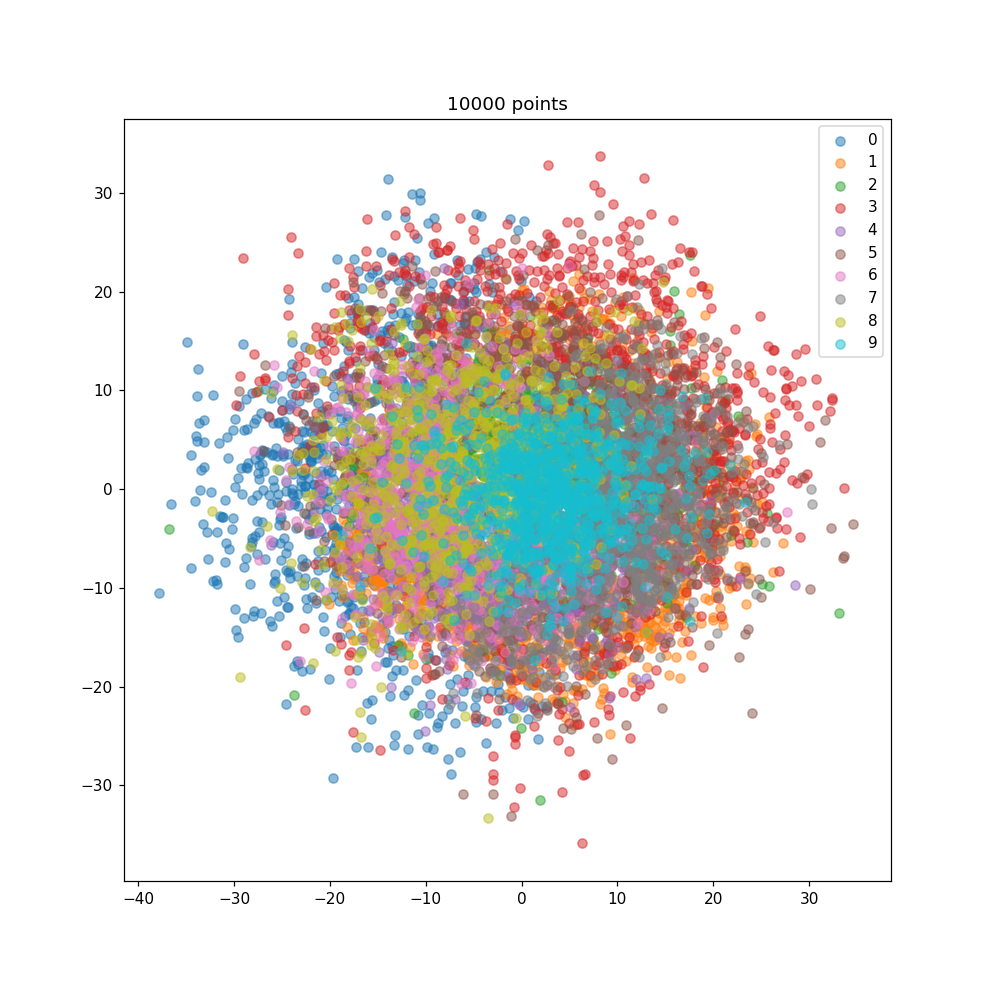

In [9]:
module_pca = PytorchModulePCA(learn.model, learn.model[3][0], learn.data.valid_dl)
module_pca(k=2)
module_pca.plot()

### Reduce
We can reduce the number of points by calling `.reduce`. By default it uses **kmeans** to properly select the new points.

<IPython.core.display.Javascript object>


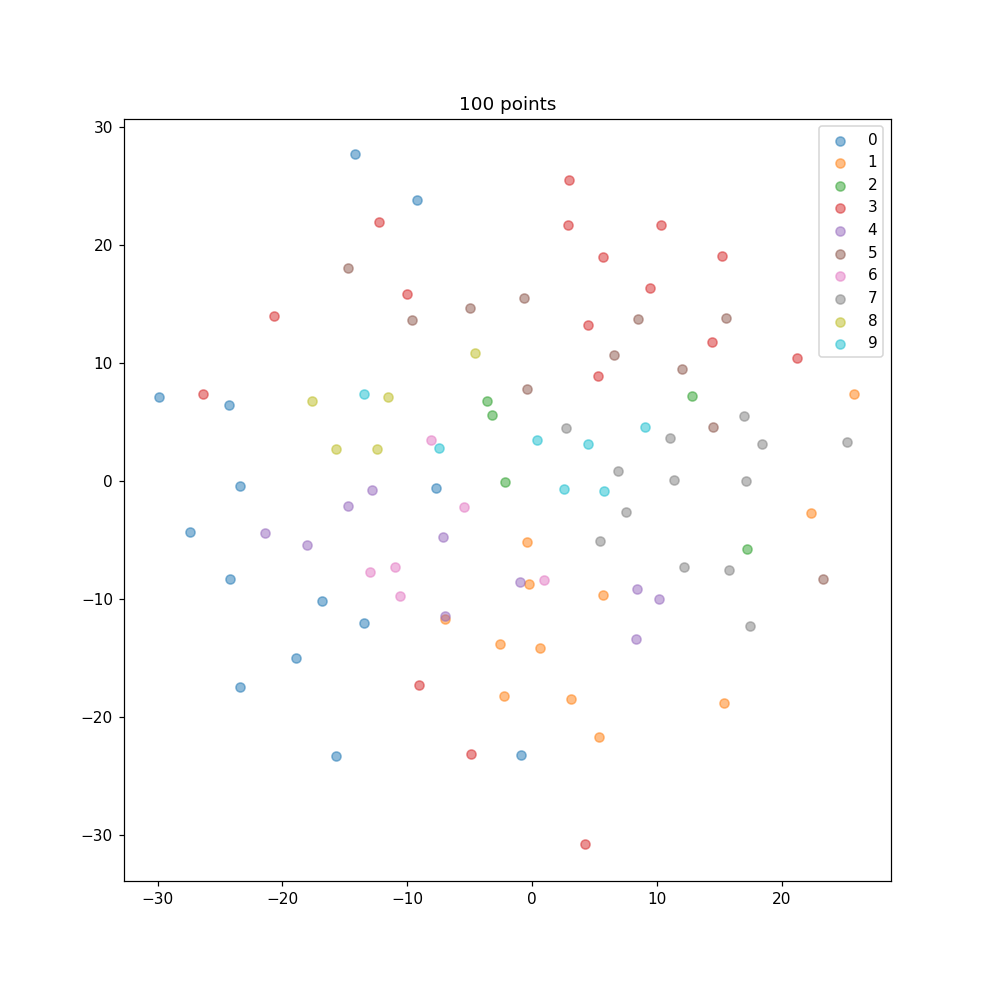

<IPython.core.display.Javascript object>


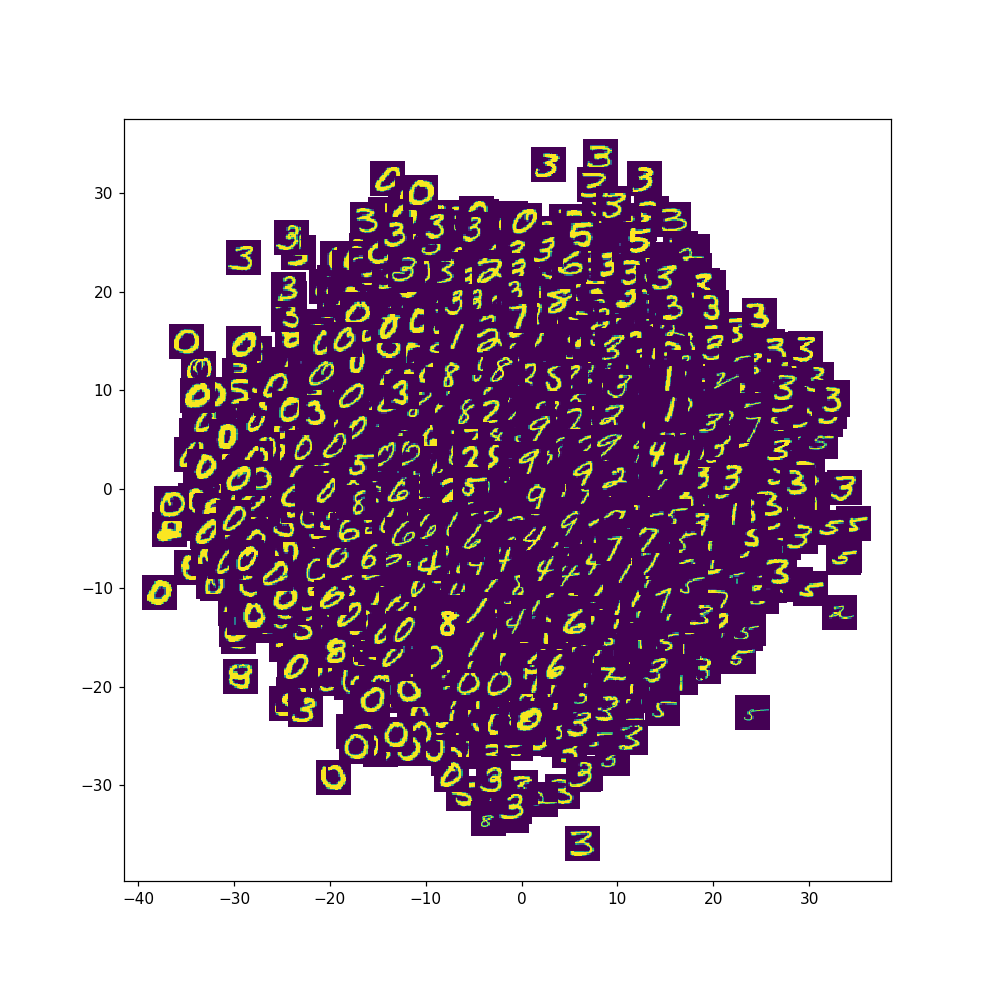

In [10]:
reduced_module_pca = module_pca.reduce(to=100)
reduced_module_pca.plot()
module_pca.annotate(zoom=0.8)

## 3D

<IPython.core.display.Javascript object>


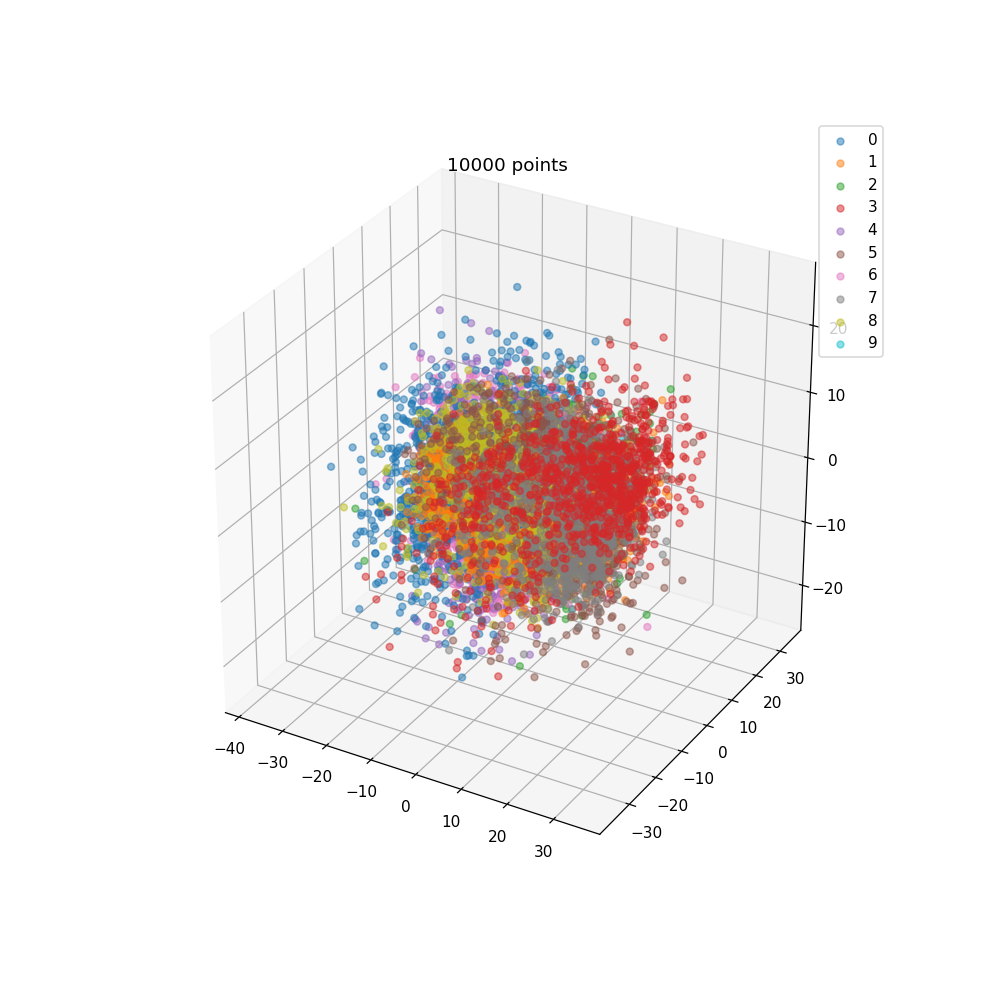

In [11]:
module_pca3d = PytorchModulePCA(learn.model, learn.model[3][0], learn.data.valid_dl)
module_pca3d(k=3)
module_pca3d.plot()


### Reduce

<IPython.core.display.Javascript object>


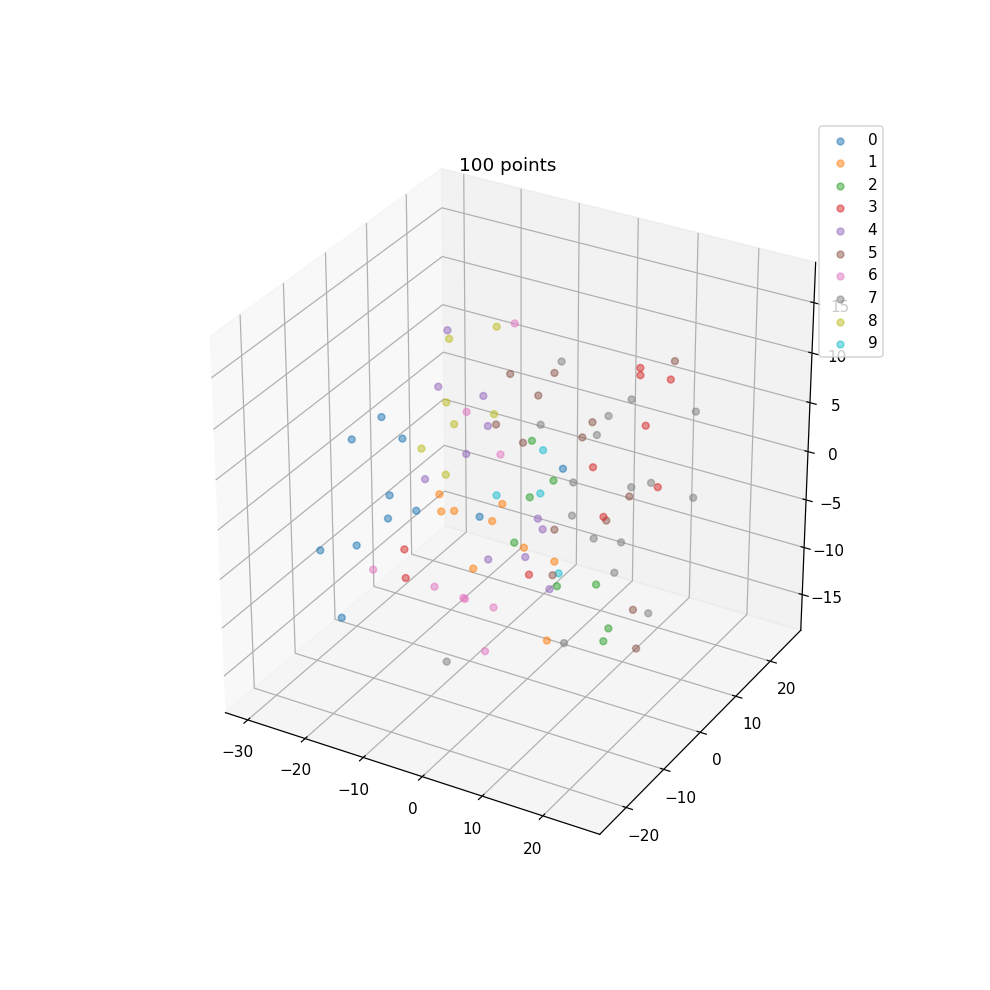

<IPython.core.display.Javascript object>


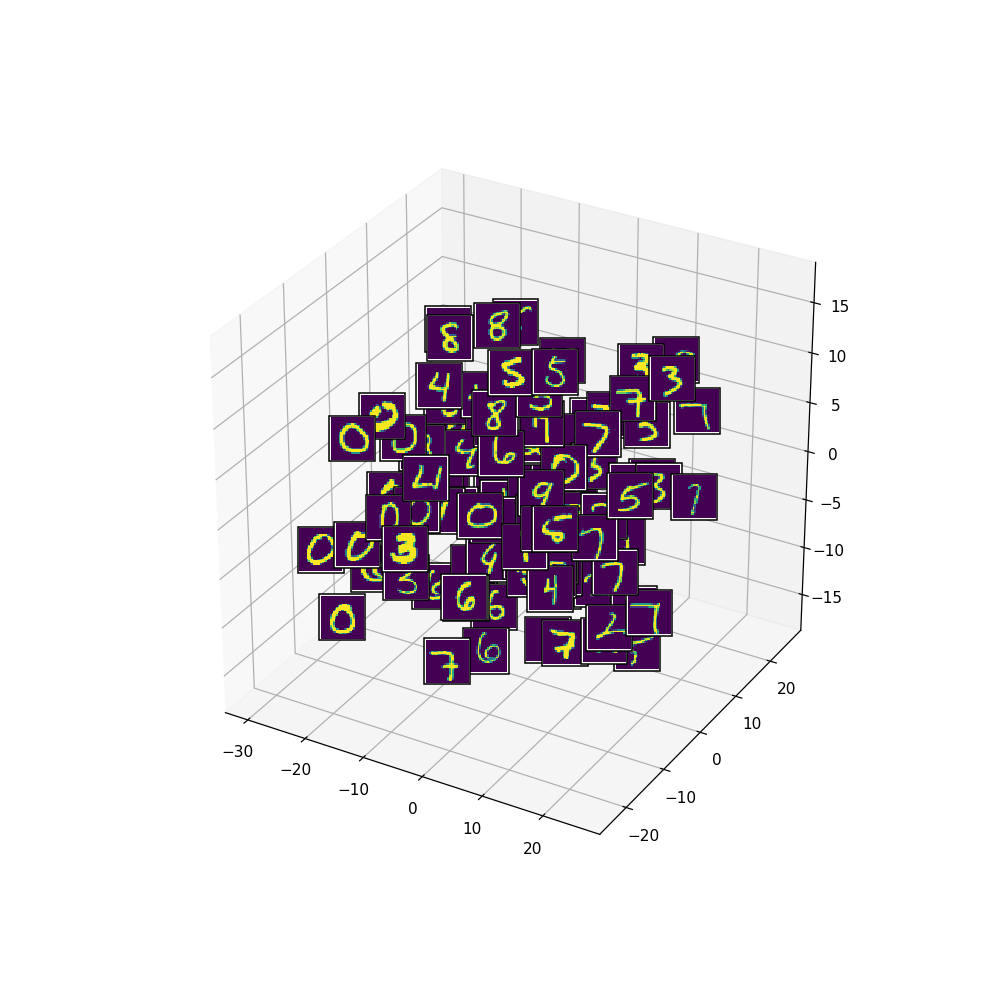

In [13]:
reduced_module_pca3d = module_pca3d.reduce(to=100)
reduced_module_pca3d.plot()
reduced_module_pca3d.annotate()